In [1]:
import datetime
from sklearn.model_selection import train_test_split, KFold
from common import compute_rmse_fraction, contri, get_tensor, create_region_df_dfc_static
from create_matrix import *
from tensor_custom_core_all import *
import multiprocessing as mp

In [2]:
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}
APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']

In [3]:
case = 2
setting = 'normal'
constant_use = True
static_use = True
source = 'Austin'
target = 'SanDiego'
random_seed = 0
train_percentage = 0
start = 1
stop = 13
year = 2014

In [4]:
def get_zero_prediction(setting, case, constant_use, static_use, source, target, random_seed, train_percentage, start, stop, year = 2014):
    
    A_store = pickle.load(open(os.path.expanduser('~/git/scalable-nilm/aaai18/predictions/case-{}-graph_{}_{}_{}_{}_As.pkl'.format(case, source, constant_use, start, stop)), 'r'))
    error_store = pickle.load(open(os.path.expanduser('~/git/scalable-nilm/aaai18/predictions/case-{}-graph_{}_{}_{}_{}_errs.pkl'.format(case, source, constant_use, start, stop)), 'r'))
    source_df, source_dfc, source_tensor, source_static = create_region_df_dfc_static(source, year, start, stop)
    target_df, target_dfc, target_tensor, target_static = create_region_df_dfc_static(target, year, start, stop)
    source_L = get_L(source_static)
    target_L = get_L(target_static)

    if constant_use == 'True':
        T_constant = np.ones(stop-start).reshape(-1 , 1)
    else:
        T_constant = None

    pred = {}
    out = {}
    n_splits = 10

    for appliance in APPLIANCES_ORDER:
        pred[appliance] = []
    best_params_global = {}
    kf = KFold(n_splits=n_splits)

    minimun = 10000

    for key_1, nested_1 in error_store.items():
        for key_2, nested_2 in nested_1.items():
            for key_3, nested_3 in nested_2.items():
                for key_4, nested_4 in nested_3.items():
                    for key_5, nested_5 in nested_4.items():
                        if nested_5 < minimun:
                            minimun = nested_5
                            best_learning_rate = key_1
                            best_num_season_factors = key_2
                            best_num_home_factors = key_3
                            best_lam = key_4
                            best_num_iterations = key_5
    print key_1, key_2, key_3, key_4, key_5

#     for outer_loop_iteration, (train_max, test) in enumerate(kf.split(target_df)):
#         # Just a random thing
#         np.random.seed(10 * random_seed + 7 * outer_loop_iteration)
#         np.random.shuffle(train_max)
#         print("-" * 80)
#         print("Progress: {}".format(100.0 * outer_loop_iteration / n_splits))
# #         print(datetime.datetime.now())
# #         sys.stdout.flush()
#         num_train = int((train_percentage * len(train_max) / 100) + 0.5)


#         if train_percentage == 100:
#             train = train_max
#             train_ix = target_df.index[train]
#             # print("Train set {}".format(train_ix.values))
#             test_ix = target_df.index[test]
#         else:
#             # Sample `train_percentage` homes
#             # An important condition here is that all homes should have energy data
#             # for all appliances for atleast one month.
#             train, _ = train_test_split(train_max, train_size=train_percentage / 100.0)
#             train_ix = target_df.index[train]
#             test_ix = target_df.index[test]


# #         print("-" * 80)
# #         print("Test set {}".format(test_ix.values))
# #         print("-" * 80)
# #         print("Current Error, Least Error, #Iterations")

#         ### Inner CV loop to find the optimum set of params. In this case: the number of iterations
#         inner_kf = KFold(n_splits=2)


#         overall_df_inner = target_df.loc[train_ix]
#         best_params_global[outer_loop_iteration] = {}

#         params = {}
#         count = 0

# #         print("******* BEST PARAMS *******")
# #         print("******* BEST PARAMS *******")
#         sys.stdout.flush()
#         # Now we will be using the best parameter set obtained to compute the predictions
#         if setting=="transfer":
#             A_source = A_store[best_learning_rate][best_num_season_factors][best_num_home_factors][best_lam][best_num_iterations]
#         else:
#             A_source = None
#         num_test = len(test_ix)
#         train_test_ix = np.concatenate([test_ix, train_ix])
#         df_t, dfc_t = target_df.loc[train_test_ix], target_dfc.loc[train_test_ix]
#         tensor = get_tensor(df_t, start, stop)
#         tensor_copy = tensor.copy()
#         # First n
#         tensor_copy[:num_test, 1:, :] = np.NaN
# #         print tensor_copy


#         L = target_L[np.ix_(np.concatenate([test, train]), np.concatenate([test, train]))]

#         H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, L,
#                                                                               best_num_home_factors,
#                                                                               best_num_season_factors,
#                                                                               num_iter=best_num_iterations, lr=best_learning_rate, dis=False,
#                                                                               lam=best_lam, random_seed = random_seed, A_known=A_source, T_known=T_constant)

    
#         HAT = multiply_case(H, A, T, case)
# #         print HAT
#         for appliance in APPLIANCES_ORDER:
#             pred[appliance].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
#         best_params_global[outer_loop_iteration] = {'Learning Rate': best_learning_rate,
#                                                     'Iterations': best_num_iterations,
#                                                     'Num season factors': best_num_season_factors,
#                                                     'Num home factors': best_num_home_factors,
#                                                     'Lambda': best_lam
#                                                     }

#     for appliance in APPLIANCES_ORDER:
#         pred[appliance] = pd.DataFrame(pd.concat(pred[appliance]))
#     for appliance in APPLIANCES_ORDER[1:]:
#         prediction = pred[appliance]
#         if appliance == 'hvac':
#             prediction = prediction[range(5-start, 11-start)]
#         out[appliance] = \
#             compute_rmse_fraction(appliance, prediction, target, start, stop)[2]
#     print out
# #     print (pd.DataFrame(out).T*pd.Series(contri['SanDiego'])).sum(axis=1)
#     return out
# #     print("Computed for: {}".format(name))
    

In [8]:
out = pickle.load(open('../predictions/zero/lr-tf-Austin-SanDiego-all.pkl','r'))
out
for case in [2, 4]:
    for setting in ['normal', 'transfer']:
        print "case-{}".format(case), setting
        print out[case]['True']['False'][setting][0.0]
        print (pd.DataFrame(out[case]['True']['False'][setting]).T*pd.Series(contri['SanDiego'])).sum(axis=1)[0]
        print "*"*20

case-2 normal
dw        16.035385
fridge     7.937031
hvac      18.931079
mw        17.099908
oven      15.301546
wm        15.816977
dtype: float64
15.1122625411
********************
case-2 transfer
dw         2.163809
fridge     9.784088
hvac      21.071625
mw         2.713056
oven       2.978464
wm         1.250149
dtype: float64
15.0820940318
********************
case-4 normal
dw         8.453122
fridge     8.346045
hvac      22.580974
mw         8.047152
oven       5.655186
wm         8.115131
dtype: float64
16.1277591633
********************
case-4 transfer
dw         1.843350
fridge     8.251440
hvac      25.593007
mw         2.088127
oven       2.576448
wm         0.863349
dtype: float64
17.0503131142
********************


In [68]:
pd.Series(contri['SanDiego'])

dw        0.029733
fridge    0.313919
hvac      0.554866
mw        0.042220
oven      0.038067
wm        0.021196
dtype: float64

In [12]:
np.random.seed(100)
n = np.random.rand(2, 3)
n

array([[ 0.54340494,  0.27836939,  0.42451759],
       [ 0.84477613,  0.00471886,  0.12156912]])

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

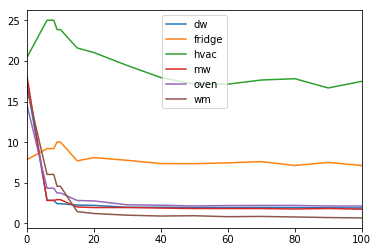

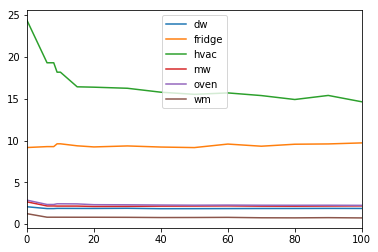

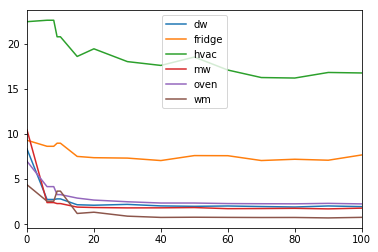

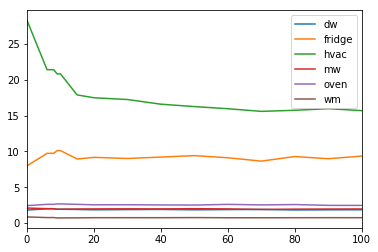

In [88]:
out = pickle.load(open('../predictions/lr-tf-Austin-SanDiego-all.pkl','r'))
for case in [2, 4]:
    for setting in ['normal', 'transfer']:
        pd.DataFrame(out[case]['True']['False'][setting]).T.plot()

In [53]:
pd.DataFrame(out[case]['True']['True'][setting]).T

,dw,fridge,hvac,mw,oven,wm
0.0,1.825981,7.983982,28.294691,2.108620,2.442053,0.866586
6.0,1.972787,13.828324,22.933958,2.577025,2.665017,0.832345
7.0,1.972787,13.828324,22.933958,2.577025,2.665017,0.832345
8.0,1.972787,13.828324,22.933958,2.577025,2.665017,0.832345
9.0,2.009597,13.629195,22.077166,2.572320,2.700422,0.847617
10.0,2.009597,13.629195,22.077166,2.572320,2.700422,0.847617
15.0,1.841005,9.750262,18.057661,2.171511,2.461591,0.782759
20.0,1.819563,9.491846,17.578985,2.157076,2.467203,0.791445
30.0,1.878657,8.914198,17.159224,2.142638,2.479270,0.779314
40.0,1.865577,9.050069,16.372204,2.086076,2.392515,0.783598


In [ ]:
error = (pd.DataFrame(out[case][constant][static][transfer]).T*pd.Series(contri['SanDiego'])).sum(axis=1)